In [1]:
import hyperopt
print("hyperopt.__version__", hyperopt.__version__)
import sklearn
print("sklearn.__version__", sklearn.__version__)
#pip install scikit-learn==1.0.2  다운그레이드 해서 테스트하기
import pandas
print("pandas.__version__", pandas.__version__)
#pip install pandas==1.3.5
import xgboost
print("xgboost.__version__", xgboost.__version__)

hyperopt.__version__ 0.2.7
sklearn.__version__ 1.0.2
pandas.__version__ 1.3.5
xgboost.__version__ 1.5.0


# XGBoost(eXtra Gradient Boost)

In [2]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
# 데이터 불러오기
dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

In [4]:
df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
df.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0                 0.07871  ...         25.38          17.33           184.60   
1                 0.05667  ...         24.99          23.41           158.80   
2                 0.05999  ...         23.57          25.53           152.50   
3                 0.09744  ...         14.91          26.50            98.87   
4                 0.05883  ...         22.54          16.67           152.20   

   worst area  worst smoothness  worst compactness  worst concavity  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   worst concave points  worst symmetry  worst fractal dimension  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 30 columns]

In [5]:
df['target'] = labels
print(dataset.target_names)
print(df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


## 1. Python XGBoost


In [6]:
# df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 컬럼이 Label임. Feature용 DataFrame은 df의 첫번째 컬럼에서 맨 마지막 두번째 컬럼까지 :-1 슬라이싱으로 추출
X_features = df.iloc[:, :-1]
y_label = df.iloc[:, -1]

In [7]:
print(X_features.shape)
print(y_label.shape)

(569, 30)
(569,)


In [8]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)


(455, 30) (114, 30)
(409, 30) (46, 30)


In [9]:
# 만약 구버전 XGBoost에서 DataFrame으로 DMatrix 생성이 안될 경우 X_train.values로 넘파이 변환.
# 학습, 검증, 테스트용 DMatrix를 생성.
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [10]:
# XGB의 하이퍼 파라미터 설정정
params = {
    'max_depth':3,
    'eta':0.05, # 학습률
    'objective':'binary:logistic', #사용하는 예측기
    'eval_metric':'logloss' #손실을 계산하는 함수
}
num_rounds = 400

In [11]:
# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval' 로 명기합니다. 
eval_list = [(dtr,'train'),(dval,'eval')] # 또는 eval_list = [(dval,'eval')] 만 명기해도 무방. 

# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds, 
                      early_stopping_rounds=50, evals=eval_list)
print(xgb_model)

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52929
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31893	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

In [12]:
import numpy as np

pred_probs = xgb_model.predict(dtest)
print('preidct( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장
preds = [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

preidct( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


### get_clf_eval 출력 함수

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_probs=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred) 
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)

    print('오차 행렬:\n', confusion)
    print(f'정확도: {accuracy}, 정밀도: {precision}, 재현율: {recall},\
    F1: {f1}, AUC:{roc_auc}')

In [14]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬:
 [[34  3]
 [ 2 75]]
정확도: 0.956140350877193, 정밀도: 0.9615384615384616, 재현율: 0.974025974025974,    F1: 0.967741935483871, AUC:0.9464724464724464


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

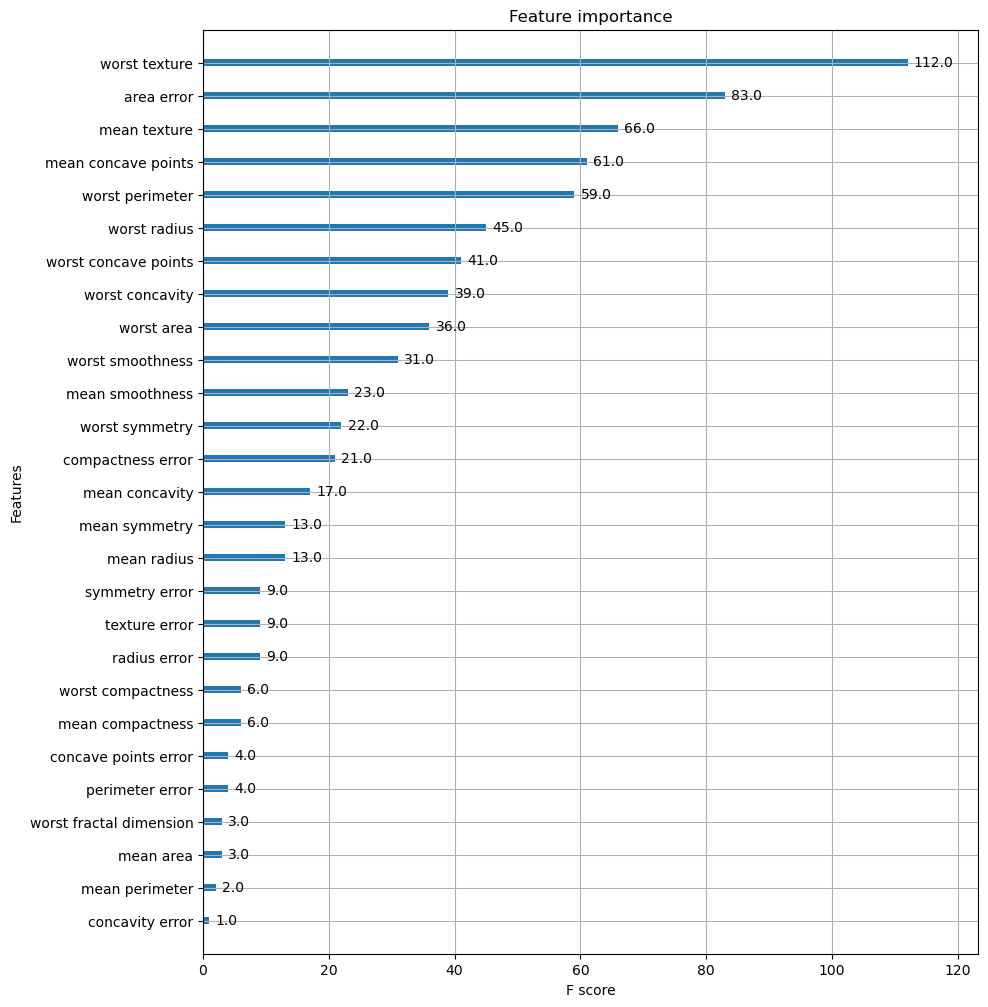

In [15]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

## 2. Sklearn XGBoost

In [16]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test,w_preds,w_preds_proba)


c:\Users\selina\.conda\envs\xgboost_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


오차 행렬:
 [[34  3]
 [ 1 76]]
정확도: 0.9649122807017544, 정밀도: 0.9620253164556962, 재현율: 0.987012987012987,    F1: 0.9743589743589742, AUC:0.9529659529659528


In [17]:
# 최종 학습 데이터와 검증 데이터 이용하여 학습과 조기 중단 적용용
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss')

# 사이킷런 래퍼일때는 파이썬 래퍼처럼(eval_list = [(dtr,'train'),(dval,'eval')]) 학습과 검증을 의미하는 문자열을 넣어주지 않아도 됨.
# 맨 앞의 튜플이 학습용 데이터, 뒤으 튜플이 검증용 데이터로 자동 인식됨.
evals = [(X_tr, y_tr),(X_val, y_val)]
xgb_wrapper.fit(X_tr,y_tr,early_stopping_rounds=50, eval_metric='logloss', eval_set=evals, verbose=True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52929
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31893	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

c:\Users\selina\.conda\envs\xgboost_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[36]	validation_0-logloss:0.12197	validation_1-logloss:0.29295
[37]	validation_0-logloss:0.11784	validation_1-logloss:0.29043
[38]	validation_0-logloss:0.11379	validation_1-logloss:0.28927
[39]	validation_0-logloss:0.10994	validation_1-logloss:0.28578
[40]	validation_0-logloss:0.10638	validation_1-logloss:0.28364
[41]	validation_0-logloss:0.10302	validation_1-logloss:0.28183
[42]	validation_0-logloss:0.09963	validation_1-logloss:0.28005
[43]	validation_0-logloss:0.09649	validation_1-logloss:0.27972
[44]	validation_0-logloss:0.09359	validation_1-logloss:0.27744
[45]	validation_0-logloss:0.09080	validation_1-logloss:0.27542
[46]	validation_0-logloss:0.08807	validation_1-logloss:0.27504
[47]	validation_0-logloss:0.08541	validation_1-logloss:0.27458
[48]	validation_0-logloss:0.08299	validation_1-logloss:0.27348
[49]	validation_0-logloss:0.08035	validation_1-logloss:0.27247
[50]	validation_0-logloss:0.07786	validation_1-logloss:0.27163
[51]	validation_0-logloss:0.07550	validation_1-logloss:

In [18]:
get_clf_eval(y_test,ws50_preds,ws50_preds_proba)

오차 행렬:
 [[34  3]
 [ 2 75]]
정확도: 0.956140350877193, 정밀도: 0.9615384615384616, 재현율: 0.974025974025974,    F1: 0.967741935483871, AUC:0.9464724464724464


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

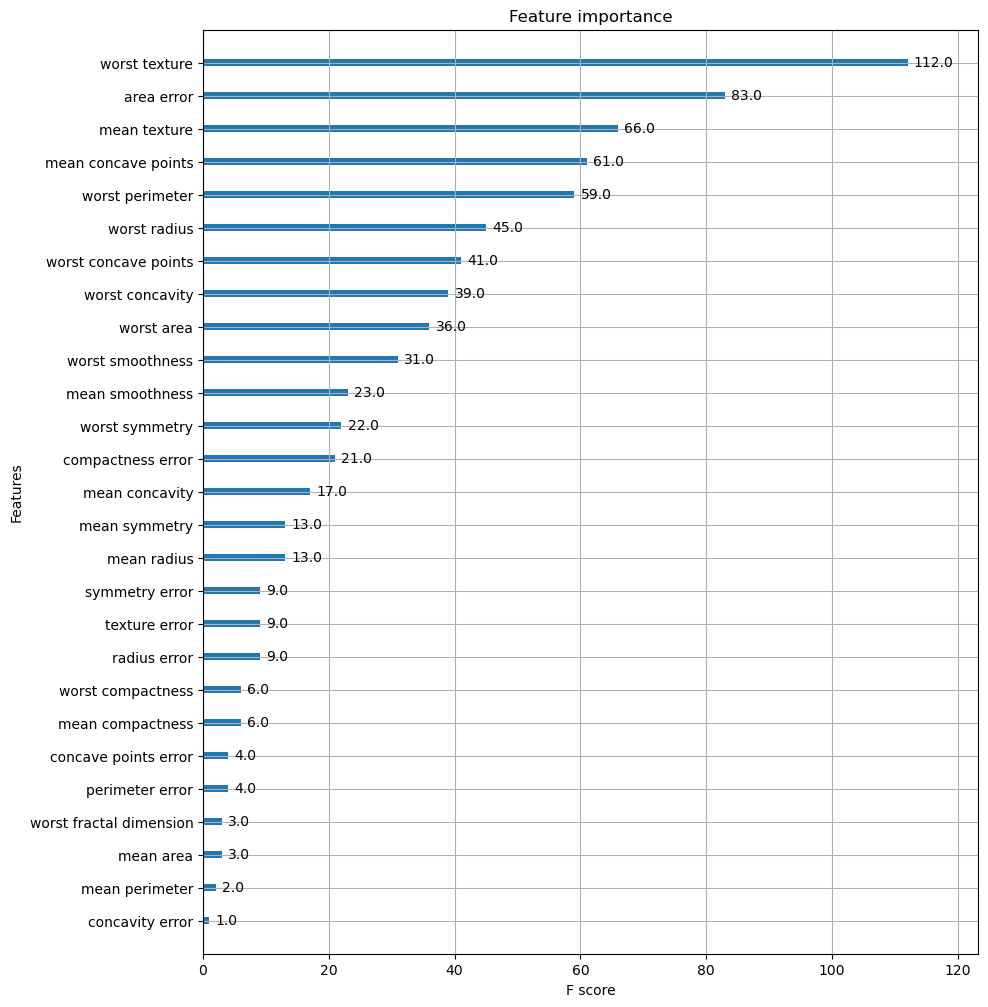

In [19]:
# 시각화 plot_importance()
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
#사이킷런 래퍼 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

# LightGBM

In [20]:
from lightgbm import LGBMClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [21]:
import lightgbm as lgb
print(lgb.__version__)

3.3.2


In [22]:
# 데이터 불러오기
dataset = load_breast_cancer()
cancer_pd = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_pd

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
0             0.27760         0.30010              0.14710         0.2419   
1             0.07864         0.08690              0.07017         0.1812   
2             0.15990         0.19740              0.12790         0.2069   
3             0.28390         0.24140              0.10520         0.2597   
4             0.13280         0.19800              0.10430         0.1809   
..                ...             ...                  ...            ...   
564           0.11590         0.24390              0.13890         0.1726   
565           0.10340         0.14400              0.09791         0.1752   
566           0.10230         0.09251              0.05302         0.1590   
567           0.27700         0.35140              0.15200         0.2397   
568           0.04362         0.00000              0.00000         0.1587   

     mean fractal dimension  ...  worst radius  worst texture  \
0                   0.07871  ...        25.380          17.33   
1                   0.05667  ...        24.990          23.41   
2                   0.05999  ...        23.570          25.53   
3                   0.09744  ...        14.910          26.50   
4                   0.05883  ...        22.540          16.67   
..                      ...  ...           ...            ...   
564                 0.05623  ...        25.450          26.40   
565                 0.05533  ...        23.690          38.25   
566                 0.05648  ...        18.980          34.12   
567                 0.07016  ...        25.740          39.42   
568                 0.05884  ...         9.456          30.37   

     worst perimeter  worst area  worst smoothness  worst compactness  \
0             184.60      2019.0           0.16220            0.66560   
1             158.80      1956.0           0.12380            0.18660   
2             152.50      1709.0           0.14440            0.42450   
3              98.87       567.7           0.20980            0.86630   
4             152.20      1575.0           0.13740            0.20500   
..               ...         ...               ...                ...   
564           166.10      2027.0           0.14100            0.21130   
565           155.00      1731.0           0.11660            0.19220   
566           126.70      1124.0           0.11390            0.30940   
567           184.60      1821.0           0.16500            0.86810   
568            59.16       268.6           0.08996            0.06444   

     worst concavity  worst concave points  worst symmetry  \
0             0.7119                0.2654          0.4601   
1             0.2416                0.1860          0.2750   
2             0.4504                0.2430          0.3613   
3             0.6869                0.2575          0.6638   
4             0.4000                0.1625          0.2364   
..               ...                   ...             ...   
564           0.4107                0.2216         

In [23]:
cancer_pd['target']= dataset.target
X_features = cancer_pd.iloc[:, :-1]
y_label = cancer_pd.iloc[:, -1]

# 1단계
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 2단계
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

# 모델
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# 조기 중단 수행
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=True)

# 예측
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, preds, pred_proba)

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

c:\Users\selina\.conda\envs\xgboost_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\selina\.conda\envs\xgboost_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[56]	training's binary_logloss: 0.0636873	valid_1's binary_logloss: 0.263128
[57]	training's binary_logloss: 0.0613354	valid_1's binary_logloss: 0.26231
[58]	training's binary_logloss: 0.0591944	valid_1's binary_logloss: 0.262011
[59]	training's binary_logloss: 0.057033	valid_1's binary_logloss: 0.261454
[60]	training's binary_logloss: 0.0550801	valid_1's binary_logloss: 0.260746
[61]	training's binary_logloss: 0.0532381	valid_1's binary_logloss: 0.260236
[62]	training's binary_logloss: 0.0514074	valid_1's binary_logloss: 0.261586
[63]	training's binary_logloss: 0.0494837	valid_1's binary_logloss: 0.261797
[64]	training's binary_logloss: 0.0477826	valid_1's binary_logloss: 0.262533
[65]	training's binary_logloss: 0.0460364	valid_1's binary_logloss: 0.263305
[66]	training's binary_logloss: 0.0444552	valid_1's binary_logloss: 0.264072
[67]	training's binary_logloss: 0.0427638	valid_1's binary_logloss: 0.266223
[68]	training's binary_logloss: 0.0412449	valid_1's binary_logloss: 0.266817
[

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

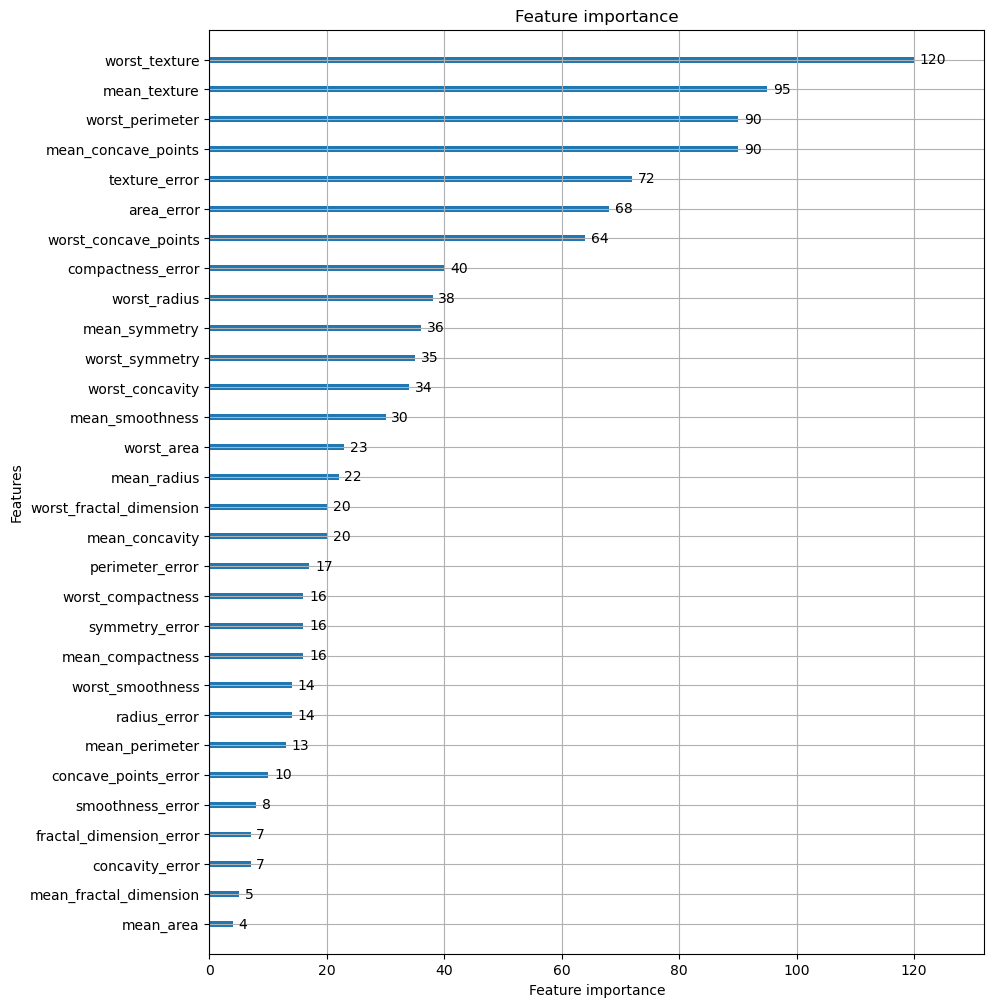

In [24]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)